In [1]:
import os

import pandas as pd

datadir = os.path.join('data')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'pearson'
dataset_path = os.path.join(datadir, 'normalized_dataset.csv')
valid_path = os.path.join(datadir, f'valid_dataset.csv')
invalid_path = os.path.join(datadir, f'invalid_dataset.csv')
basedir = "/home/ymerel/storage/results/"
jobname = "auditory_sosym"
result_path = f"{basedir}{jobname}"

In [2]:
dataset = pd.read_csv(dataset_path, delimiter=';')
valid_df = pd.read_csv(valid_path, delimiter=';')
invalid_df = pd.read_csv(invalid_path, delimiter=';')


print(f"{len(dataset)} configs in dataset")

correlations = pd.read_csv(corr_path, delimiter=';')
print(f"{len(correlations)} correlations in matrix")

matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)
distance_matrix = 1 - matrix

dataset.head(1010)

1001 configs in dataset
1004004 correlations in matrix


,slice_timing_correction/ref_slice/middle,distorsion_correction,signal_modeling/temporal_noise_autocorrelation/FAST,slice_timing_correction,signal_modeling/temporal_noise_autocorrelation/AR1,spatial_normalization/algorithm/linear,motion_correction_realignment/register_to/mean,signal_modeling/hrf/temporal_derivs,spatial_normalization/algorithm/DARTEL,signal_modeling/hrf/canonical,...,spatial_normalization/bias_fwhm,spatial_smoothing/fwhm,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/interpolation/bspline,id,pearson_from_ref,spearman_from_ref,pearson_from_mean,spearman_from_mean
0,False,False,True,False,False,False,True,True,False,False,...,0,6,False,False,False,d73e0359ec51c3b847656b8f2bc157b083dae2057d53a4...,0.103517,0.082454,0.263128,0.245781
1,False,False,True,True,False,False,False,False,False,True,...,0,6,True,False,False,e012bd4d9bab5a18593441c76f48ccc732bca3390703ff...,0.149047,0.124797,0.337434,0.305455
2,True,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,850e4d92a370900eede8982155772f1ba014ab468eef7c...,0.956003,0.882291,0.854730,0.697912
3,False,False,True,True,False,False,False,True,False,False,...,0,6,True,False,False,84c27a9d96a41f520b1de0bf3ef88093bcf9761b45e45e...,0.724838,0.588650,0.760644,0.584104
4,False,False,True,True,False,False,True,False,False,False,...,0,6,True,False,False,0c7beba1bec8f4ff1c5ebff7e2af248230c4ce91c27775...,0.095768,0.074215,0.272972,0.252439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,True,False,False,True,True,False,True,False,False,False,...,0,6,True,False,False,478226e8b91fd9e223848097af04e9841a0c7c8bebe003...,0.900571,0.798534,0.815145,0.667142
997,False,False,False,False,True,False,True,True,False,False,...,0,6,False,False,False,49b2e420e59aac429dbf460a5814461a2b645eb20f2387...,0.872822,0.767594,0.786408,0.635235
998,False,False,False,True,True,False,False,False,False,True,...,0,6,False,False,True,2a1e8f3ad608486da7eb9f165fa6389c641a895232a3dc...,0.657927,0.548311,0.758439,0.600097
999,True,False,True,True,False,False,True,False,False,True,...,0,6,False,False,False,cd5f0844e445d6ab574976706eb2929d22072940c7433e...,0.562473,0.446034,0.774017,0.610582


In [3]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split


def predict_metric(path, target_metric, iteration, train_sizes=[], test_size=200):
    
    results_list = []
    
    ignored = [
        col for col in dataset.columns
        if col.endswith('from_ref') or col.endswith('from_mean')
    ]
    ignored.extend(['id'])
    
    test_ds = pd.read_csv(os.path.join(path, f'sub_dataset_{test_size}_test_{iteration}.csv'), delimiter=';')
    y_test = test_ds[target_metric]
    X_test = test_ds.drop(columns=ignored).copy()
    
    for train_size in train_sizes:
        
        train_ds = pd.read_csv(os.path.join(path, f'sub_dataset_{train_size}_train_{iteration}.csv'), delimiter=';')
        
        y_train = train_ds[target_metric]
        X_train = train_ds.drop(columns=ignored).copy()

        regressor = DecisionTreeRegressor(random_state=42)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
    
        mape = mean_absolute_percentage_error(y_test, y_pred)
    
        features = X_train.columns
        importances = regressor.feature_importances_
        feat_importances = {feat: imp for feat, imp in zip(features, importances) if imp > 0.0}
    
        # Store the decision tree as text
        tree_rules = export_graphviz(
                regressor,
                out_file=None,
                feature_names=X_train.columns.values,
                filled=True,
                rounded=True,
                special_characters=True,
                leaves_parallel=True,
                proportion=True
            )
    
        results_list.append({
            'metric': target_metric,
            'train_size': train_size,
            'MAPE': mape,
            'decision_tree': tree_rules,
            'feature_importances': feat_importances
        })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results_list)

    return results_df

# Regression decision tree on full dataset
Given a configuration, try to predict the value of the correlation of this configuration result to
- the reference image
- the mean image

For prediction, means results are precomputed for each subset

In [ ]:
metrics = ['pearson_from_ref', 'pearson_from_mean']

all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = predict_metric('regression/full', metric, i, [80, 160, 240, 320, 400, 480, 560, 640, 720])
        results_df['iteration'] = i
        all_results.append(results_df)

# Concatenate all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Display the final DataFrame
final_results_df.head(100)

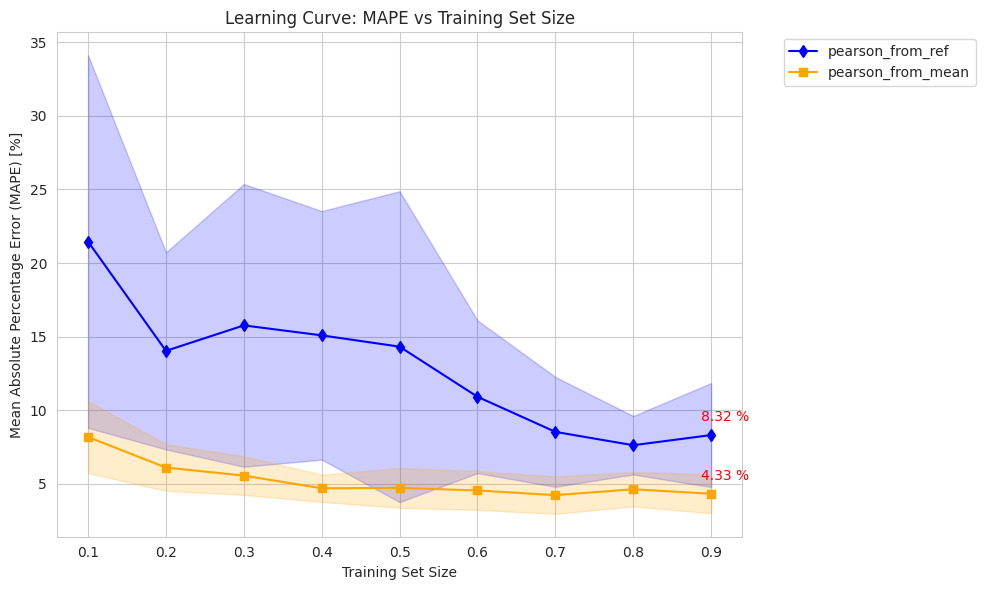

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

grouped = final_results_df.groupby(['metric', 'train_size'])['MAPE'].agg(['mean', 'std']).reset_index()
pivot_df = grouped.pivot(index='train_size', columns='metric', values=['mean', 'std'])

mean_mape_ref = pivot_df['mean']['pearson_from_ref']
std_mape_ref = pivot_df['std']['pearson_from_ref']
mean_mape_mean = pivot_df['mean']['pearson_from_mean']
std_mape_mean = pivot_df['std']['pearson_from_mean']

# Plotting
plt.figure(figsize=(10, 6))
train_sizes = np.linspace(0.1, 0.9, 9)

# Plot for pearson_from_ref
plt.plot(
    train_sizes,
    mean_mape_ref * 100,  # Multiply by 100 to get percentage
    marker='d',
    label='pearson_from_ref',
    color='blue'
)
plt.fill_between(
    train_sizes,
    (mean_mape_ref - std_mape_ref) * 100,  # Multiply by 100
    (mean_mape_ref + std_mape_ref) * 100,  # Multiply by 100
    alpha=0.2,
    color='blue'
)
plt.annotate(
    f'{mean_mape_ref.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_ref.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Plot for pearson_from_mean
plt.plot(
    train_sizes,
    mean_mape_mean * 100,  # Multiply by 100 to get percentage
    marker='s',
    label='pearson_from_mean',
    color='orange'
)
plt.fill_between(
    train_sizes,
    (mean_mape_mean - std_mape_mean) * 100,  # Multiply by 100
    (mean_mape_mean + std_mape_mean) * 100,  # Multiply by 100
    alpha=0.2,
    color='orange'
)
plt.annotate(
    f'{mean_mape_mean.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_mean.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]')
plt.title('Learning Curve: MAPE vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()


# Regression decision tree on valid dataset

In [6]:
metrics = ['pearson_from_ref', 'pearson_from_mean']

all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = predict_metric('regression/valid', metric, i, [59, 118, 178, 237, 297, 356, 415, 475, 534], 149)
        results_df['iteration'] = i
        all_results.append(results_df)

# Concatenate all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Display the final DataFrame
final_results_df.head(100)

,metric,train_size,MAPE,decision_tree,feature_importances,iteration
0,pearson_from_ref,59,0.030812,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
1,pearson_from_ref,118,0.025019,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
2,pearson_from_ref,178,0.018261,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
3,pearson_from_ref,237,0.018668,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
4,pearson_from_ref,297,0.015220,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
...,...,...,...,...,...,...
95,pearson_from_ref,356,0.016166,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6
96,pearson_from_ref,415,0.014182,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6
97,pearson_from_ref,475,0.013224,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6
98,pearson_from_ref,534,0.011550,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6


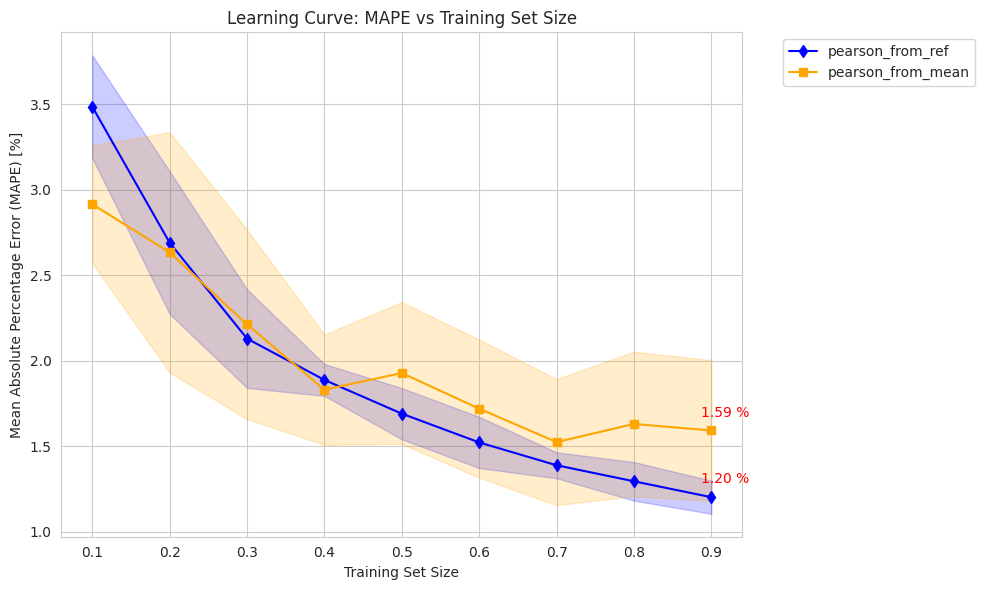

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

grouped = final_results_df.groupby(['metric', 'train_size'])['MAPE'].agg(['mean', 'std']).reset_index()
pivot_df = grouped.pivot(index='train_size', columns='metric', values=['mean', 'std'])

mean_mape_ref = pivot_df['mean']['pearson_from_ref']
std_mape_ref = pivot_df['std']['pearson_from_ref']
mean_mape_mean = pivot_df['mean']['pearson_from_mean']
std_mape_mean = pivot_df['std']['pearson_from_mean']

# Plotting
plt.figure(figsize=(10, 6))
train_sizes = np.linspace(0.1, 0.9, 9)

# Plot for pearson_from_ref
plt.plot(
    train_sizes,
    mean_mape_ref * 100,  # Multiply by 100 to get percentage
    marker='d',
    label='pearson_from_ref',
    color='blue'
)
plt.fill_between(
    train_sizes,
    (mean_mape_ref - std_mape_ref) * 100,  # Multiply by 100
    (mean_mape_ref + std_mape_ref) * 100,  # Multiply by 100
    alpha=0.2,
    color='blue'
)
plt.annotate(
    f'{mean_mape_ref.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_ref.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Plot for pearson_from_mean
plt.plot(
    train_sizes,
    mean_mape_mean * 100,  # Multiply by 100 to get percentage
    marker='s',
    label='pearson_from_mean',
    color='orange'
)
plt.fill_between(
    train_sizes,
    (mean_mape_mean - std_mape_mean) * 100,  # Multiply by 100
    (mean_mape_mean + std_mape_mean) * 100,  # Multiply by 100
    alpha=0.2,
    color='orange'
)
plt.annotate(
    f'{mean_mape_mean.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_mean.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]')
plt.title('Learning Curve: MAPE vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression decision tree on invalid dataset

In [8]:
metrics = ['pearson_from_ref', 'pearson_from_mean']

all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = predict_metric('regression/invalid', metric, i, [20, 41, 61, 82, 102, 123, 143, 164, 184], 52)
        results_df['iteration'] = i
        all_results.append(results_df)

# Concatenate all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)

# Display the final DataFrame
final_results_df.head(100)

,metric,train_size,MAPE,decision_tree,feature_importances,iteration
0,pearson_from_ref,20,0.622585,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 2...,1
1,pearson_from_ref,41,0.221415,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
2,pearson_from_ref,61,0.256909,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
3,pearson_from_ref,82,0.214100,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
4,pearson_from_ref,102,0.148986,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,1
...,...,...,...,...,...,...
95,pearson_from_ref,123,0.229581,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6
96,pearson_from_ref,143,0.154540,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6
97,pearson_from_ref,164,0.203233,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6
98,pearson_from_ref,184,0.175440,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,6


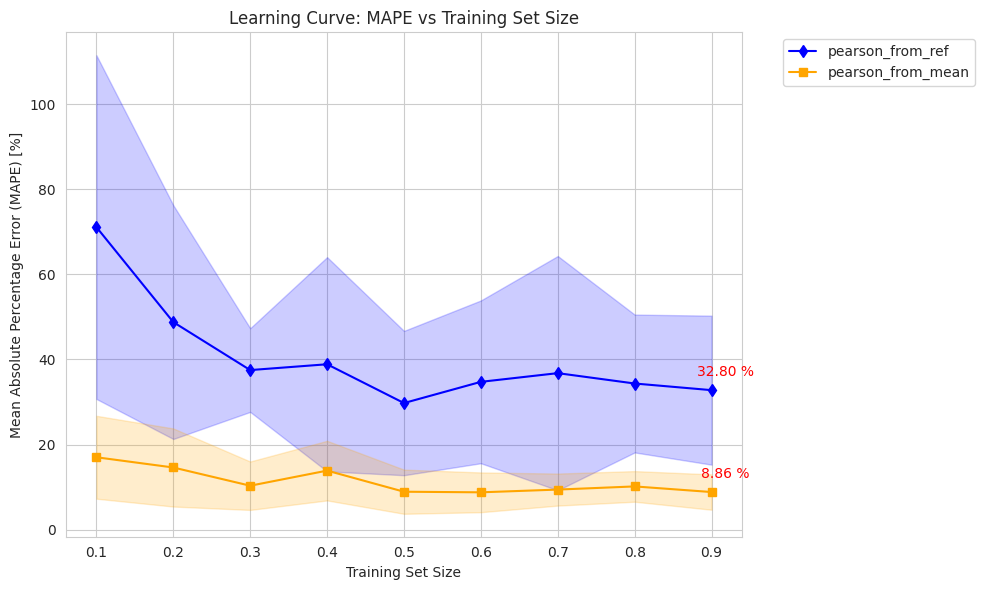

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

grouped = final_results_df.groupby(['metric', 'train_size'])['MAPE'].agg(['mean', 'std']).reset_index()
pivot_df = grouped.pivot(index='train_size', columns='metric', values=['mean', 'std'])

mean_mape_ref = pivot_df['mean']['pearson_from_ref']
std_mape_ref = pivot_df['std']['pearson_from_ref']
mean_mape_mean = pivot_df['mean']['pearson_from_mean']
std_mape_mean = pivot_df['std']['pearson_from_mean']

# Plotting
plt.figure(figsize=(10, 6))
train_sizes = np.linspace(0.1, 0.9, 9)

# Plot for pearson_from_ref
plt.plot(
    train_sizes,
    mean_mape_ref * 100,  # Multiply by 100 to get percentage
    marker='d',
    label='pearson_from_ref',
    color='blue'
)
plt.fill_between(
    train_sizes,
    (mean_mape_ref - std_mape_ref) * 100,  # Multiply by 100
    (mean_mape_ref + std_mape_ref) * 100,  # Multiply by 100
    alpha=0.2,
    color='blue'
)
plt.annotate(
    f'{mean_mape_ref.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_ref.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Plot for pearson_from_mean
plt.plot(
    train_sizes,
    mean_mape_mean * 100,  # Multiply by 100 to get percentage
    marker='s',
    label='pearson_from_mean',
    color='orange'
)
plt.fill_between(
    train_sizes,
    (mean_mape_mean - std_mape_mean) * 100,  # Multiply by 100
    (mean_mape_mean + std_mape_mean) * 100,  # Multiply by 100
    alpha=0.2,
    color='orange'
)
plt.annotate(
    f'{mean_mape_mean.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_mean.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]')
plt.title('Learning Curve: MAPE vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()